In [42]:
%load_ext autoreload
%autoreload 2

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
from scipy import stats
from collections import Counter
import networkx as nx
from multiomics_benchmark import helper_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
np.set_printoptions(suppress=True)

# Plot Accuracy

In [44]:
# Define your datasets
datasets = ['brain','breast', 'colorectal', 'glioma', 'head_neck', 'kidney_renal','lung', 
            'lung_squamous',  'omics', 'ovarian', 'pan_kidney', 'PreE', 
            'stomach_esophageal', 'thyroid', 'uterine']

# Define omics names for each dataset
options = defaultdict(lambda: ["Methylation", "miRNA", "RNA", "RPPA", "SCNV"], 
                      {'omics': ['cfRNA', 'proteo_lum', 'serum_lum', 'microbiome', 'CyTOF', 'metabolome', 'proteo_som'],
                       'PreE': ['cfRNA', 'lipidome', 'metabol-plasma', 'metabol-urine', 'proteome', 'microbiome'],
                       'glioma': ["Methylation", "miRNA", "RNA", "RPPA", "SCNV"],
                       'brain': ["Methylation", "miRNA", "RNA", "RPPA", "SCNV"],
                       'ovarian': ["Methylation", "miRNA", "RNA", "RPPA", "SCNV"],
                       'uterine':["Methylation", "miRNA", "RPPA", "SCNV"]
                      })

In [45]:
r_limit = 0.5
r_limit_name = 'limit_{}'.format(r_limit)

In [46]:
dataset_results = []

for i in range(len(datasets)):
    with open('/home/mxenoc/workspace/multiomics-benchmark/plots/accuracy_calculations/'+r_limit_name+'/'+datasets[i]+'.pkl', 'rb') as f:
        dataset_results.append(pickle.load(f))
        
dataset_results = pd.concat(dataset_results)

pivot_df_ind = dataset_results.pivot(index='dataset', columns='models', values='percentage')

In [47]:
dataset_results = []

for i in range(len(datasets)):
    with open('/home/mxenoc/workspace/multiomics-benchmark/plots/accuracy_calculations/'+r_limit_name+'/stacked/'+datasets[i]+'.pkl', 'rb') as f:
        dataset_results.append(pickle.load(f))
        
dataset_results = pd.concat(dataset_results)

pivot_df_stk = dataset_results.pivot(index='dataset', columns='models', values='percentage')

In [48]:
# If you want to combine results
pivot_df = pd.concat([pivot_df_ind, pivot_df_stk], axis=1)

# Individual plots

In [49]:
cmap_greys = plt.get_cmap('Greys')
cmap_reds = plt.get_cmap('Reds')

In [50]:
r_p_all = []
individual_totals = {}

#for dataset in datasets:
dataset = datasets[0]

omics = options[dataset]
n_samples = 50

/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/mxenoc/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(n

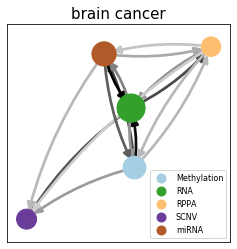

In [51]:
with open('/home/mxenoc/workspace/multiomics-benchmark/results/'+dataset+'/individual/Lasso.pkl', 'rb') as f:
    mdl = pickle.load(f)

r_p_list = []
models_res = []
res = []    

r_limit = 0.5
r_limit_name = 'limit_{}'.format(r_limit)

for omic_dataset in range(len(omics)):
    all_features = defaultdict(list)
    for k in range(n_samples):
        each_feature = defaultdict(list)
        for l in range(len(omics)-1):                

            x = mdl['observed_test'][omic_dataset][k]
            y = mdl['prediction_test'][omic_dataset][k][l]

            each_feature['r'].append(stats.spearmanr(x,y)[0])                
            each_feature['p'].append(stats.spearmanr(x,y)[1])
            each_feature['predictor'].append(omics[l])

        all_features['r'].append(each_feature['r'])
        all_features['p'].append(each_feature['p'])
        all_features['predictor'].append(each_feature['predictor'])

    r = np.hstack(all_features['r'])
    p = np.hstack(all_features['p'])
    predictors = np.hstack(all_features['predictor'])

    r_p = pd.DataFrame({'r': r, 'p': p, 'predictor': predictors, 'target': omics[omic_dataset]})
    r_p = r_p[(r_p['r']>r_limit) & (r_p['p']<=0.05)]
    r_p_list.append(r_p)
    res.append(len(r_p))

test = pd.concat(r_p_list)
test = test.drop(['r', 'p'], axis = 1)

###DO NOT USE THIS FOR MULTIOMICS
#test['predictor'] = test['predictor'].str.partition('_')[0]
#test['target'] = test['target'].str.partition('_')[0]
#########

dataset_predictability = Counter(test['target'])
dataset_predictability = pd.DataFrame(dataset_predictability.items())
dataset_predictability.columns = ['features', 'group']

dataset_predictors = Counter(test['predictor'])
dataset_predictors = pd.DataFrame(dataset_predictors.items())
dataset_predictors.columns = ['features', 'group']

links = pd.DataFrame(test.groupby(test.columns.tolist(),as_index=False).size())
links.reset_index(level=0, inplace=True)
links.reset_index(level=0, inplace=True)
columns_titles = ["predictor","target", "size"]
links = links.reindex(columns = columns_titles)
links.columns = ['var1', 'var2', 'weight']
#links.loc[-1] = ['RNA', 'RNA', 0]
#links.loc[4] = ['lipidome', 'lipidome', 0]
#links.loc[5] = ['microbiome', 'microbiome', 0]

###DO NOT USE THIS FOR MULTIOMICS
#links['var1'] = links['var1'].str.partition('_')[0]
#links['var2'] = links['var2'].str.partition('_')[0]
#######

G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr=True, create_using=nx.DiGraph())

# Edges you want to include
threshold = -1

# Edges you want to plot
edges_filtered = [(u,v) for (u, v, e) in G.edges(data=True) if e['weight'] > threshold]
weights_filtered = [e['weight'] for (u, v, e) in G.edges(data=True) if e['weight'] > threshold]

# Choose the layout
#pos = nx.spring_layout(G, scale = 0.85, k = 0.8)
#pos = nx.spring_layout(G, scale = 0.65, k = 0.9)
pos = nx.spring_layout(G, scale = 0.5, k = 0.9)
#pos = nx.circular_layout(G)

node_colors = dataset_predictability.set_index('features')
node_colors['groups'] = node_colors.index
# Reindex your nodes to match the graph's nodes
node_colors_reind = node_colors.reindex(G.nodes())
node_colors_reind['groups'] = node_colors_reind.index
node_colors_reind['groups'] = pd.Categorical(node_colors_reind['groups'])
node_colors_reind['group'] = node_colors_reind['group'].fillna(0)
node_colors_percent = (node_colors_reind['group']/((len(omics)-1)*50))

popular_predictors = dataset_predictors.set_index('features')
# Reindex your nodes to match the graph's nodes
popular_predictors_reind = popular_predictors.reindex(G.nodes())
#node_colors_reind['group'] = pd.Categorical(node_colors_reind['group'])
popular_predictors_percent = (popular_predictors_reind/((len(omics)-1)*50))*100

individual_totals[dataset] = popular_predictors_percent

# Make a list of the labels you want to show on the graph
labels = {}    
for node in G.nodes():
    #set the node name as the key and the label as its value 
    labels[node] = node
    

Colour_map = dict(zip(node_colors_reind.index, node_colors_reind['groups'].cat.codes))
values = [Colour_map.get(node) for node in G.nodes()]
maxval = np.max(values) 

node_colors_percent = node_colors_percent.fillna(0)

node_map = plt.get_cmap('Paired')

nx.draw_networkx_nodes(G, with_labels=False, pos = pos, 
                         #node_color = node_colors_reind['groups'].cat.codes, #'pink',
                          node_color = [node_map(v/maxval) for v in set(values)],
                          node_size = node_colors_percent*1500+100) 

#nx.draw_networkx_labels(G, pos, labels, font_color = 'black', font_weight = 'bold', font_size = 9)

nx.draw_networkx_edges(G, pos, edgelist = edges_filtered, 
                               edge_color = weights_filtered, 
                               edge_cmap = helper_functions.truncate_colormap(cmap_greys, 0.3, 1), 
                               width = 2.7, arrowsize=15,
                               arrows=True, connectionstyle='arc3, rad = 0.1')

for v in set(values):
    plt.scatter([],[], c=[node_map(v/maxval)], label=list(G.nodes())[v])

plt.legend(fontsize=8, markerscale=1.5)
plt.title(dataset+' cancer', fontsize = 15)
#plt.title(dataset, fontsize = 15)
#plt.title('normal pregnancy', fontsize = 15)
#plt.title('head/neck cancer', fontsize = 15)
#plt.title('kidney renal cancer', fontsize = 15)
#plt.title('lung squamous cancer', fontsize = 15)
#plt.title('pan-kidney cancer', fontsize = 15)
#plt.title('preeclampsia', fontsize = 15)
#plt.title('stomach/esophageal cancer', fontsize = 15)
#plt.title('preeclampsia', fontsize = 15)

#Finally, redraw the labels at their new position.
figure = plt.gcf() # get current figure
figure.set_size_inches(4, 4)
#plt.savefig('/home/mxenoc/workspace/multiomics-benchmark/plots/'+dataset+'.pdf', dpi = 500)

# Individual plots

In [37]:
pivot_df_L = pivot_df['Lasso']

In [38]:
with open('/home/mxenoc/workspace/multiomics-benchmark/results/individual_totals.pkl', 'rb') as f:
    individual_totals = pickle.load(f)

In [39]:
individual_totals['omics'].loc['RNA'] = [0]

individual_totals['PreE'].loc['microbiome'] = [0]
individual_totals['PreE'].loc['lipidome'] = [0]

In [40]:
for i in individual_totals:
    row = ['multimodal', pivot_df_L[pivot_df_L.index == i][0]]
    individual_totals[i].loc[row[0]] = row[1]

Text(0.5, 1.0, 'normal pregnancy')

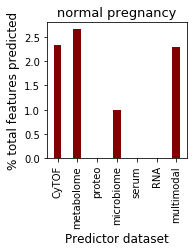

In [41]:
dataset = 'omics'

fig = plt.figure(figsize = (2.5, 2.5)) 
  
# creating the bar plot 
plt.bar(list(individual_totals[dataset].index), individual_totals[dataset]['group'].tolist(), color ='maroon', width = 0.4) 
  
plt.xlabel("Predictor dataset", fontsize = 12) 
plt.ylabel("% total features predicted", fontsize = 12) 
plt.title(dataset) 
plt.xticks(rotation=90)

#plt.legend(fontsize=8, markerscale=1.5)

#plt.title(dataset+' cancer', fontsize = 13)
#plt.title(dataset, fontsize = 13)
plt.title('normal pregnancy', fontsize = 13)
#plt.title('head/neck cancer', fontsize = 13)
#plt.title('kidney renal cancer', fontsize = 13)
#plt.title('lung squamous cancer', fontsize = 13)
#plt.title('pan-kidney cancer', fontsize = 13)
#plt.title('preeclampsia', fontsize = 13)
#plt.title('stomach/esoph. cancer', fontsize = 13)

#plt.savefig('/home/mxenoc/workspace/benchmark/plots/'+'bars_'+dataset+'.png', dpi=500, bbox_inches='tight')

# Boxplot with all datasets

In [19]:
pivot_df_ind['dataset'] = pivot_df_ind.index

In [20]:
box_df = pd.melt(pivot_df_ind, id_vars=['dataset'])

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

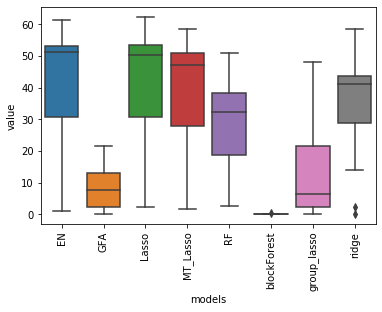

In [21]:
sns.boxplot(x="models", y="value", data=box_df)
plt.xticks(rotation=90)

# Compare stacked lasso with normal lasso

In [22]:
df_scatter = pivot_df[['Lasso', 'opt_Lasso_True']]

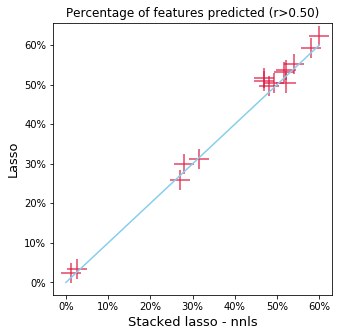

In [26]:
fig=plt.figure(figsize=(5, 5))

p1=sns.regplot(data=df_scatter, x="opt_Lasso_True", y="Lasso", fit_reg=False, marker="+", color="crimson", scatter_kws={'s':400})
p1.yaxis.set_major_formatter(mtick.PercentFormatter())
p1.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Percentage of features predicted (r>0.50)', fontsize = 12)
plt.xlabel('Stacked lasso - nnls', fontsize = 13)
plt.ylabel('Lasso', fontsize = 13)

# add annotations one by one with a loop
#for line in range(0,df_scatter.shape[0]):
#     p1.text(df_scatter.stacked_nnls[line]+0.2, df_scatter.Lasso[line], df_scatter.index[line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')
        
p1.plot([0, 60], [0, 60], c='skyblue')  
#os.chdir('/home/mxenoc/workspace/benchmark/plots')
#plt.savefig('lasso_vs_stacked_'+r_limit_name+'.png', dpi=500, bbox_inches='tight')